In [5]:
import numpy as np
import torch 
import matplotlib.pyplot as plt

import sigkernel as ksig_pde
import sigkernel_ as ksig_disc
import utils.data
from generators.synthetic_generators import *
from generators.ESN import ESNGenerator, ESNAsTarget
from models.trainer_ESN_MMD import train_ESN_MMD
from sigkernel_.loss import compute_mmd_loss
from utils.analyse_training import plot_loss_from_run, inspect_run_and_mmd, acf_analysis, plot_W_history_vs_fixed
from utils.kernel_helpers import median_heuristic_sigma, tune_tau_coef_for_cv

%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype=torch.float64

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generator and ESN

In [6]:
# Generator and ESN details ----------------------
T = 200 # length of time series
N = 20  # number of samples
target_rho = 0.99
xi_ma_theta = None # based on the ACF at the end
d = 1   # dimension of time series

# Shared by both ESN
h, m, d = 500, 20, 1 # ESN hyperparameters: reservoir size, input dimension (\xi : randomness), output dimension
activation = "tanh"
quad_feedback = False # whether to include quadratic feedback in the ESN reservoir (to capture some nonlinearity and volatility clustering)
quad_gain = 0.1 # if set to 0.0 then no quadratic feedback

# ESN estimator
A = 0.9 * torch.randn(h, h) / (h ** 0.5) # ESN reservoir weight matrix
C = torch.randn(h, m) / (m ** 0.5) # ESN input weight matrix

# ESN target
# A_target = 0.9 * torch.randn(h, h) / (h ** 0.5) # ESN reservoir weight matrix
# C_target = torch.randn(h, m) / (m ** 0.5) # ESN input weight matrix
A_target = A.clone()
C_target = C.clone()
W_fixed = torch.randn(d, h) / (h ** 0.5)   
target_esn = ESNGenerator(A_target, C_target, out_dim=d, xi_scale=1.0, eta_scale=0.05, activation=activation, target_rho=target_rho, xi_ma_theta=xi_ma_theta, quad_feedback=quad_feedback, quad_gain=quad_gain)
with torch.no_grad():
    target_esn.W.copy_(W_fixed.to(dtype=target_esn.W.dtype, device=target_esn.W.device))
target_esn.W.requires_grad_(False)

# Define data generator and esn
target_generator = ESNAsTarget(target_esn, T_default=T)
esn = ESNGenerator(A, C, out_dim=d, xi_scale=1.0, eta_scale=0.05, activation=activation, target_rho=target_rho, xi_ma_theta=xi_ma_theta, quad_feedback=quad_feedback, quad_gain=quad_gain)

# Kernels

In [7]:
noise = Noise("normal")
with torch.no_grad():
    X = target_generator.generate(N=N, noise=noise).to(device=device, dtype=dtype)
    Z = esn(T=T, N=N).to(device=device, dtype=dtype)
print(f"Generated data shapes: X: {X.shape}, Z: {Z.shape}")
median_heuristic_sigma = median_heuristic_sigma(X,Z)
print(f"Median heuristic sigma: {median_heuristic_sigma:.6f}")

Generated data shapes: X: torch.Size([20, 200, 1]), Z: torch.Size([20, 200, 1])
Median heuristic sigma: 23.011206


In [8]:
# Define the discretized signature kernel
static_kernel_type    = 'rbf' # type of static kernel to use - rbf, rbfmix, rq, rqmix, rqlinear for
n_levels              = 10 # number of levels in the truncated signature kernel
# disc_sig_kernel_sigma = 1e-3 # bandwidth parameter for the static kernel
disc_sig_kernel_sigma = median_heuristic_sigma # bandwidth parameter for the static kernel

kwargs_disc_sig = {
    'static_kernel_type': static_kernel_type,
    'n_levels': n_levels,
    'kernel_sigma': disc_sig_kernel_sigma,
}

sig_disc_kernel = ksig_disc.kernels.get_discretized_signature_kernel(**kwargs_disc_sig)

#---------------------------------
# Define the pde signature kernel
# pde_sig_sigma = 1e1 # bandwidth parameter for the static kernel
pde_sig_sigma = median_heuristic_sigma # bandwidth parameter for the static kernel
static_kernel = ksig_pde.RBFKernel(sigma=pde_sig_sigma) # define static kernel

# Initialize the corresponding signature kernel
sig_pde_kernel = ksig_pde.SigKernel(static_kernel, dyadic_order=0)

#---------------------------------
# Define static kernel
static_sigma = median_heuristic_sigma # bandwidth parameter for the static kernel
rbf_kernel = ksig_disc.kernels.RBFKernel(sigma=static_sigma)

#---------------------------------
# Volterra kernel
ld_coef = 0.7
tau_best, cv_best, spec_best = tune_tau_coef_for_cv(X, ld_coef=ld_coef)
tau_coef = tau_best
volterra_kernel = ksig_disc.kernels.VolterraKernel(ld_coef=ld_coef, tau_coef=tau_coef)
volterra_kernel.fit(X) # fitting is needed to compute lambda, tau and the normalization constant
print(f"Best tau: {tau_best}, CV: {cv_best}")

Best tau: 0.7525, CV: 0.007809794717788503


### Choose which kernel

In [9]:
# choose one:
# kernel = sig_disc_kernel      # discretized signature kernel
kernel = sig_pde_kernel        # pde signature kernel
# kernel = rbf_kernel           # static kernel
# kernel = volterra_kernel      # volterra kernel

if "sig" in kernel.__class__.__name__.lower() or "volt" in kernel.__class__.__name__.lower():
    kernel_mode = "sequential"
else:
    kernel_mode = "static"

print(f"Using kernel: {kernel.__class__.__name__} with kernel mode: {kernel_mode}")
# initial mmd:
initial_mmd = compute_mmd_loss(kernel, X, Z) if kernel_mode == "sequential" else compute_mmd_loss(kernel, X.reshape(X.shape[0], -1), Z.reshape(Z.shape[0], -1))
print(f"Initial MMD with {kernel.__class__.__name__} kernel: {initial_mmd:.6f}")

mmd_sig_disc = compute_mmd_loss(sig_disc_kernel, X, Z)
mmd_rbf = compute_mmd_loss(rbf_kernel, X.reshape(X.shape[0], -1), Z.reshape(Z.shape[0], -1))
mmd_sig_pde = compute_mmd_loss(sig_pde_kernel, X, Z)
print(f"Initial MMD (sig disc kernel): {mmd_sig_disc:.6f}")
print(f"Initial MMD (RBF kernel): {mmd_rbf:.6f}")
print(f"Initial MMD (sig pde kernel): {mmd_sig_pde:.6f}")

Using kernel: SigKernel with kernel mode: sequential
Initial MMD with SigKernel kernel: 1.890289
Initial MMD (sig disc kernel): 2.029323
Initial MMD (RBF kernel): 0.097984
Initial MMD (sig pde kernel): 1.890289


# Define parameters

In [ ]:
train_params = {
    "epochs": 1000,
    "batch_size": N,
    "T": T,
    "d": d,
    "target_rho": target_rho,
    "esn": esn,
    "target_generator": target_generator,
    "noise": noise,
    "kernel": kernel,
    "kernel_mode": kernel_mode,
}

if "dataloader" in locals() and dataloader is not None:
    run_name = f"esn_vs_{dataloader.__class__.__name__}_{kernel.__class__.__name__}"
elif "target_generator" in locals() and target_generator is not None:
    run_name = f"esn_vs_{target_generator.__class__.__name__}_{kernel.__class__.__name__}"
else:
    raise ValueError("Neither dataloader nor target_generator is defined.")

optim_params = {
    "lr": 1e-3,
    "lr_factor": 0.5,
    "plateau_patience": 75,
    "max_lr_drops": 3,
    "early_stopping_patience": 250,
    "min_lr": 1e-6,
}

loss_params = {
    "lead_lag": False,
    "lags": 1,
    "num_losses": 20,
}

io_params = {
    "out_dir": "./runs",
    "run_name": run_name,
    "save_every": 50,
}

misc_params = {
    "dtype": torch.float64,
    "device": device,
}

kwargs = {
    **train_params,
    **optim_params,
    **loss_params,
    **io_params,
    **misc_params,
}

### Observe the generated paths before training

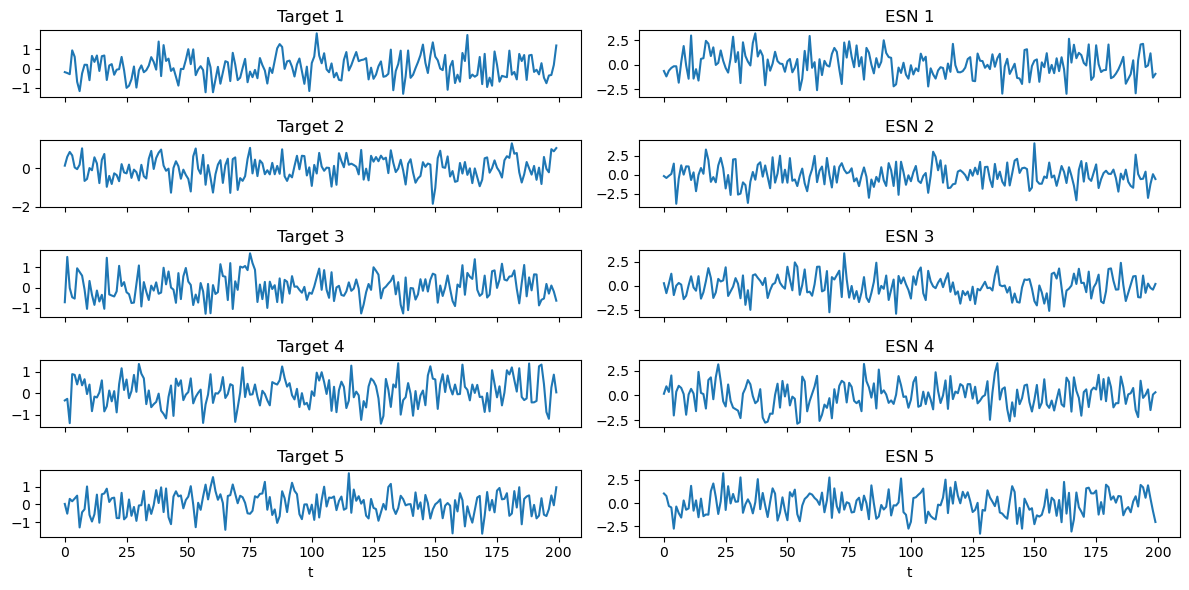

MMD: 0.13278032931656525


In [ ]:
inspection = inspect_run_and_mmd(results=None, kwargs=kwargs, n_examples=5, kernel_mmd = None)   

# Training

In [ ]:
results = train_ESN_MMD(**kwargs)

Noise(kind='normal', params=None)


train:  27%|██▋       | 267/1000 [00:38<01:53,  6.48it/s, avg_k=-.000479, drops=1, loss=-.00196, lr=0.0005]

LR drop 1/3: lr -> 0.0005


train:  34%|███▍      | 341/1000 [00:49<02:03,  5.34it/s, avg_k=-.000487, drops=1, loss=0.00246, lr=0.0005] 

LR drop 2/3: lr -> 0.00025


train:  42%|████▏     | 416/1000 [01:00<02:04,  4.68it/s, avg_k=0.000157, drops=2, loss=-.00124, lr=0.00025] 

LR drop 3/3: lr -> 0.000125


train:  44%|████▍     | 440/1000 [01:06<01:25,  6.58it/s, avg_k=-.000703, drops=3, loss=0.00226, lr=0.000125] 

Early stopping at epoch 440 (best avg_20 -0.00172122 at epoch 190, lr_drops_used=3)


# Visualize and analyse results

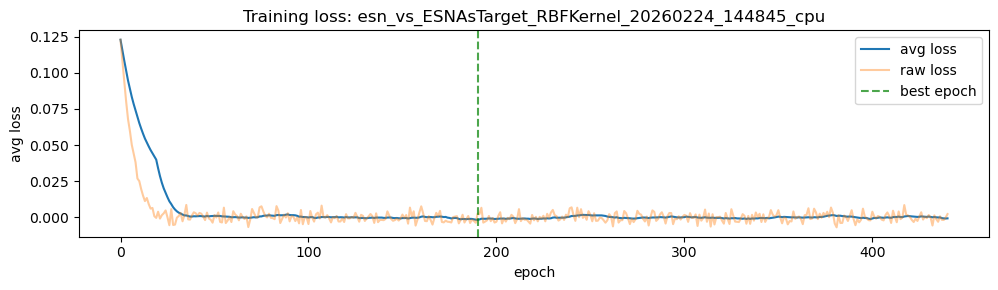

Final average loss: -0.0007
Final loss: 0.0023
Best average loss: -0.0017 at epoch 190


In [ ]:
losses = plot_loss_from_run(results, kwargs, overlay_raw=True, log_scale=False, overlay_lr = True, mark_best_and_drops=True)
print(f"Final average loss: {losses['avg_losses'][-1]:.4f}")
print(f"Final loss: {losses['losses'][-1]:.4f}")
print(f"Best average loss: {losses['best_avg_loss']:.4f} at epoch {losses['best_epoch']}")


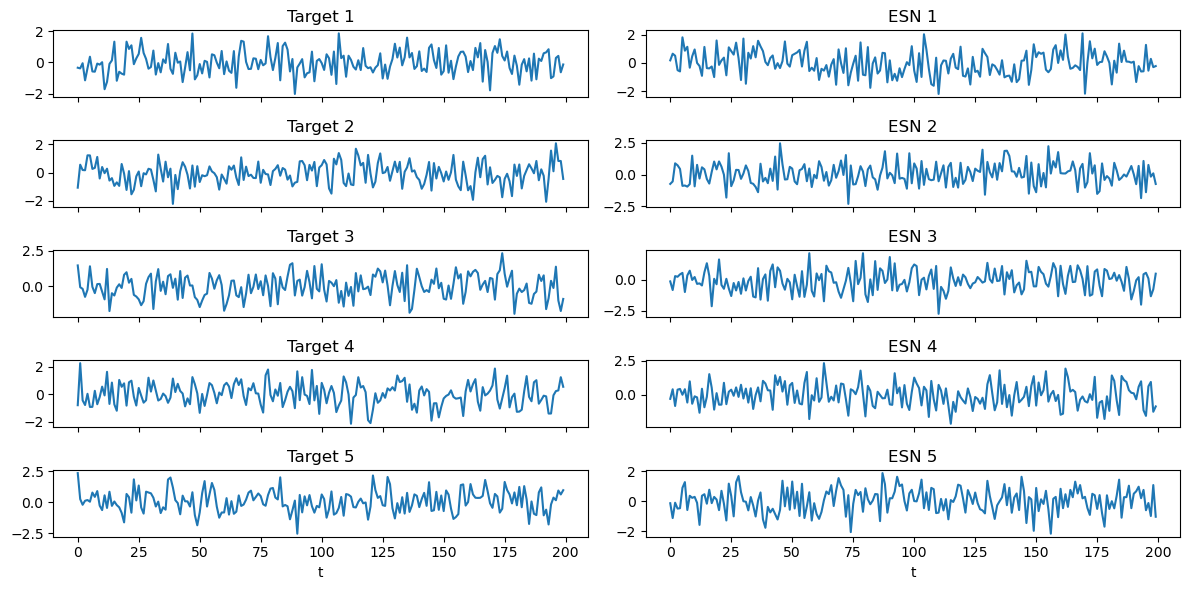

MMD: 0.0010156568147305922


In [ ]:
inspection = inspect_run_and_mmd(results, kwargs, n_examples=5, kernel_mmd = rbf_kernel, use_best=True)   

# ACF analysis

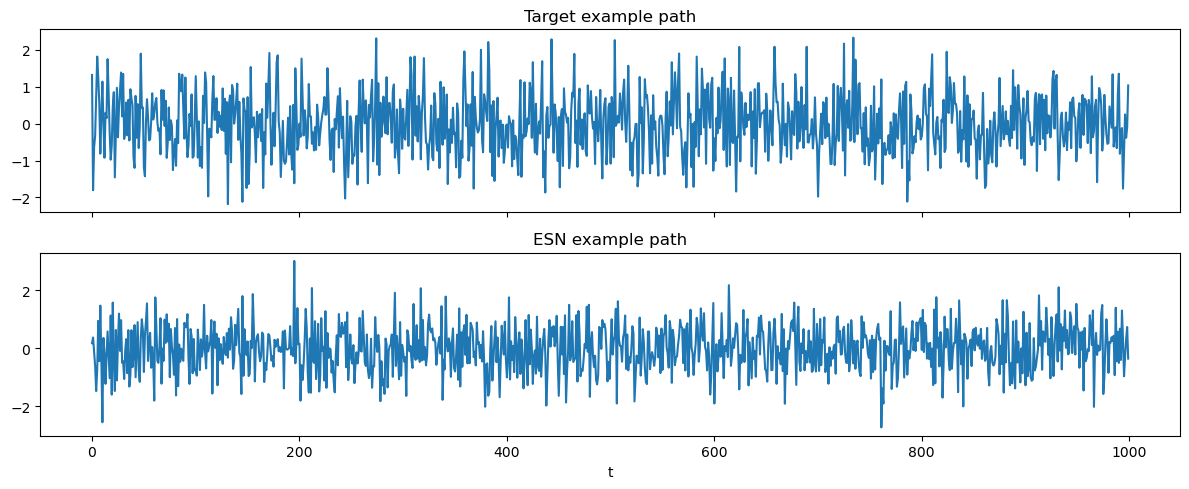

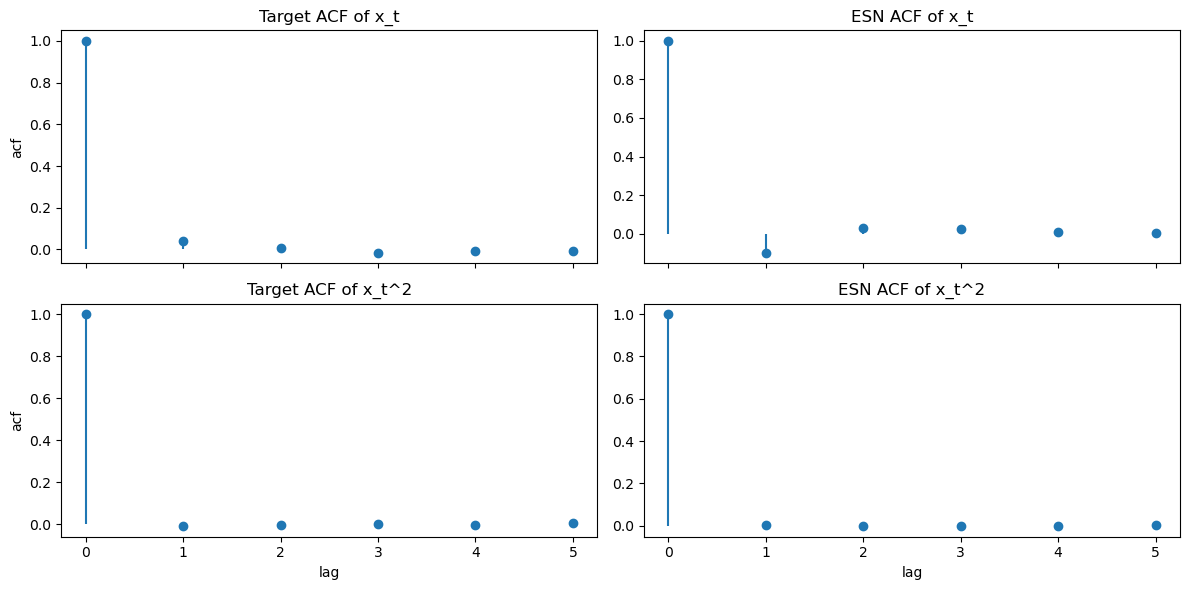

In [ ]:
out = acf_analysis(results, kwargs, T_acf=1000, N_paths=100, lag_acf=5)

# Compare W_fixed vs W_learned

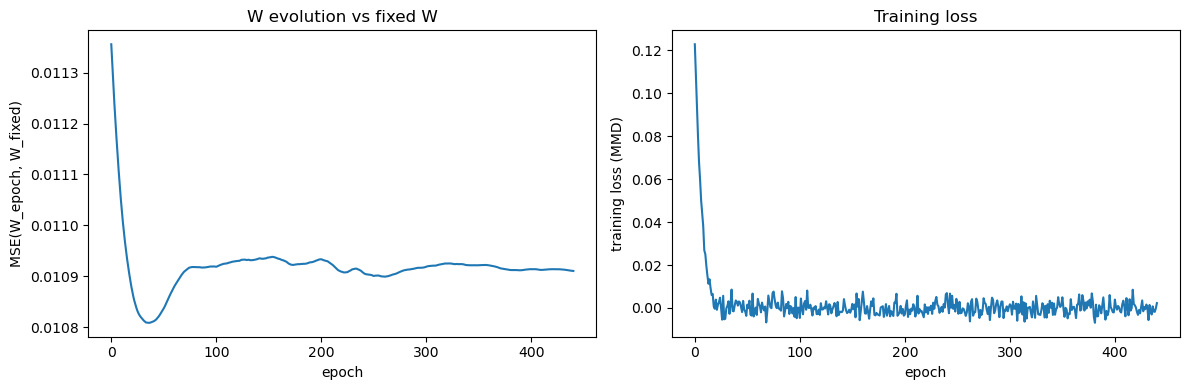

In [ ]:
W_analysis = plot_W_history_vs_fixed(results["run_path"], W_fixed)

# BFGS trial 

In [ ]:
# import torch

# def fit_W_by_lbfgs(
#     *,
#     esn,
#     X_target: torch.Tensor,      # (B,T,d)
#     kernel,
#     kernel_mode: str,            # "static" or "sequential"
#     lead_lag: bool = False,
#     lags: int = 1,
#     xi: torch.Tensor | None = None,     # (B,T,m) fixed drive; if None, ESN samples its own
#     t_tilt: torch.Tensor | None = None, # optional
#     max_iter: int = 200,
#     history_size: int = 20,
#     lr: float = 1.0,
#     tol_grad: float = 1e-10,
#     tol_change: float = 1e-12,
#     verbose: bool = True,
# ):
#     """
#     Fits W to minimize MMD(X_target, Z(W)) with L-BFGS.
#     Assumes ESN state evolution does not depend on W (true in your ESNGenerator).
#     For cleanest behavior set esn.eta_scale = 0 and pass eta=0 (we do).
#     """
#     device = esn.A.device
#     dtype = esn.A.dtype
#     X_target = X_target.to(device=device, dtype=dtype)

#     B, T, d = X_target.shape
#     if d != esn.d:
#         raise ValueError(f"X_target last dim d={d} must match esn.d={esn.d}")

#     # Fix eta to zero so the objective is deterministic in W
#     eta0 = torch.zeros(B, T, esn.d, device=device, dtype=dtype)

#     # Precompute reservoir states once
#     esn.eval()
#     with torch.no_grad():
#         Z0, Xhist = esn(T=T, N=B, xi=xi, eta=eta0, return_states=True)  # Xhist: (B,T,h)

#     # Make W trainable
#     W = torch.nn.Parameter(esn.W.detach().clone())
#     opt = torch.optim.LBFGS(
#         [W],
#         lr=lr,
#         max_iter=max_iter,
#         history_size=history_size,
#         line_search_fn="strong_wolfe",
#         tolerance_grad=tol_grad,
#         tolerance_change=tol_change,
#     )

#     def mmd_from_W():
#         Z = Xhist @ W.T  # (B,T,d)
#         if t_tilt is not None:
#             Z = Z + t_tilt.to(device=device, dtype=dtype)

#         if kernel_mode == "static":
#             Xk = X_target.reshape(B, -1)
#             Zk = Z.reshape(B, -1)
#         else:
#             Xk, Zk = X_target, Z

#         return compute_mmd_loss(kernel, Xk, Zk, lead_lag, lags)

#     loss_trace = []

#     def closure():
#         opt.zero_grad(set_to_none=True)
#         loss = mmd_from_W()
#         loss.backward()
#         return loss

#     # Run LBFGS (it will call closure multiple times)
#     loss0 = float(mmd_from_W().detach().cpu())
#     if verbose:
#         print("Initial MMD:", loss0)

#     opt.step(closure)

#     loss1 = float(mmd_from_W().detach().cpu())
#     if verbose:
#         print("Final MMD:", loss1)

#     # Write back into ESN if you want
#     with torch.no_grad():
#         esn.W.copy_(W)

#     return {"W": W.detach().cpu(), "mmd_initial": loss0, "mmd_final": loss1}

In [ ]:
# 1) Generate a fixed target batch
B = 128
T = 200
noise = Noise("normal")

with torch.no_grad():
    X = target_generator.generate(N=B, T=T, noise=noise).to(dtype=esn.A.dtype, device=esn.A.device)

# 2) Fit W by LBFGS
lbfgs_results = fit_W_by_lbfgs(
    esn=esn,
    X_target=X,
    kernel=kernel,
    kernel_mode=kernel_mode,
    lead_lag=False,
    lags=0,
    xi=None,         # let ESN sample; for a stricter test, pass a fixed xi tensor
    max_iter=200,
    lr=1.0,
)

ValueError: Buffer dtype mismatch, expected 'double' but got 'float'

In [ ]:
# W_lbfgs = lbfgs_results["W"]  # returned by fit_W_by_lbfgs

# Wf = W_fixed.detach().cpu()
# Wb = W_lbfgs.detach().cpu()

# mse = ((Wb - Wf)**2).mean().item()
# mse0 = (Wf**2).mean().item()
# print("E[W_fixed^2] =", mse0)
# print("relative MSE  =", mse / (mse0 + 1e-12))
# print("||W_fixed||_F =", torch.linalg.norm(Wf).item())
# print("||W_lbfgs||_F =", torch.linalg.norm(Wb).item())
# print("||diff||_F    =", torch.linalg.norm(Wb - Wf).item())

E[W_fixed^2] = 0.0019781277514994144
relative MSE  = 9.607655556105081
||W_fixed||_F = 0.994516909122467
||W_lbfgs||_F = 2.9068636894226074
||diff||_F    = 3.0826263427734375


In [10]:
import torch

@torch.no_grad()
def make_common_noise(esn, N, T, *, dtype=torch.float64):
    device = esn.A.device
    xi = torch.randn(N, T, esn.m, device=device, dtype=dtype) * float(esn.xi_scale)
    eta0 = torch.zeros(N, T, esn.d, device=device, dtype=dtype)
    return xi, eta0

def fit_W_mmd_lbfgs_common_noise(
    *,
    esn_model,
    esn_target,
    kernel,
    kernel_mode: str,   # "static" or "sequential"
    N: int,
    T: int,
    lead_lag: bool = False,
    lags: int = 1,
    max_iter: int = 200,
):
    device = esn_model.A.device
    dtype = torch.float64  # force double for sigkernel

    esn_model = esn_model.to(device=device, dtype=dtype).eval()
    esn_target = esn_target.to(device=device, dtype=dtype).eval()

    # common noise, zero output noise
    xi, eta0 = make_common_noise(esn_model, N, T, dtype=dtype)

    with torch.no_grad():
        Zt, _ = esn_target(T=T, N=N, xi=xi, eta=eta0, return_states=True)
        _, Xm = esn_model(T=T, N=N, xi=xi, eta=eta0, return_states=True)

        Zt = Zt.to(dtype=dtype)
        Xm = Xm.to(dtype=dtype)

    W = torch.nn.Parameter(esn_model.W.detach().clone().to(dtype=dtype))
    opt = torch.optim.LBFGS([W], lr=1.0, max_iter=max_iter, line_search_fn="strong_wolfe")

    def loss_from_W():
        Zm = Xm @ W.T  # (N,T,d), float64

        if kernel_mode == "static":
            Xk = Zt.reshape(N, -1)
            Yk = Zm.reshape(N, -1)
        else:
            Xk, Yk = Zt, Zm

        return compute_mmd_loss(kernel, Xk, Yk, lead_lag, lags)

    def closure():
        opt.zero_grad(set_to_none=True)
        loss = loss_from_W()
        loss.backward()
        return loss

    m0 = float(loss_from_W().detach().cpu())
    opt.step(closure)
    m1 = float(loss_from_W().detach().cpu())

    with torch.no_grad():
        esn_model.W.copy_(W)

    return {"mmd_initial": m0, "mmd_final": m1, "W_fit": W.detach().cpu()}

In [ ]:
torch.set_default_dtype(torch.float64)
esn.eta_scale = 0.0
target_esn.eta_scale = 0.0
out = fit_W_mmd_lbfgs_common_noise(
    esn_model=esn,
    esn_target=target_esn,
    kernel=kernel,
    kernel_mode=kernel_mode,
    N=128,
    T=200,
)

W_lbfgs = out["W_fit"]
# compare_W_lbfgs_to_fixed(W_lbfgs=W_lbfgs, W_fixed=W_fixed)

In [ ]:
W_lbfgs = lbfgs_results["W"]  # returned by fit_W_by_lbfgs

Wf = W_fixed.detach().cpu()
Wb = W_lbfgs.detach().cpu()

mse = ((Wb - Wf)**2).mean().item()
mse0 = (Wf**2).mean().item()
print("E[W_fixed^2] =", mse0)
print("relative MSE  =", mse / (mse0 + 1e-12))
print("||W_fixed||_F =", torch.linalg.norm(Wf).item())
print("||W_lbfgs||_F =", torch.linalg.norm(Wb).item())
print("||diff||_F    =", torch.linalg.norm(Wb - Wf).item())